# Cities in Motion: Student Hackathon

This notebook covers initial data exploration of the Urban Scanner dataset.

In [1]:
import os
os.chdir("..")

from pandas import DataFrame
from geopandas import GeoDataFrame
import pandas as pd
import numpy as np

from data import *
from model import *
from preprocess import *
from postprocess import *

run_dir = "run/model-2025-10-16_09-11"
N_COLLOC = 5_000
LAYERS = [3, 30, 30, 30, 30, 3]

model = PINN(layers=LAYERS)

def load_trained_pinn(layers, run_dir, device="mps", use_best=True):
    """
    Load a trained PINN model from a given run directory.

    Args:
        layers (list[int]): Network architecture, e.g. [3, 128, 128, 64, 3]
        run_dir (str): Path to run directory containing model weights, e.g. "run/model-2025-10-16_12-00"
        device (str): "cpu" or "cuda"
        use_best (bool): If True, loads 'best_model.pt'; otherwise loads 'final_model.pt'

    Returns:
        model (PINN): The loaded and ready-to-evaluate PINN model.
    """
    # --- Rebuild model ---
    model = PINN(layers, activation=Sin)
    model.to(device)

    # --- Choose which weights to load ---
    model_path = f"{run_dir}/best_model.pt" if use_best else f"{run_dir}/final_model.pt"

    # --- Load weights ---
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()

    print(f"Loaded {'best' if use_best else 'final'} model from: {model_path}")
    return model

model = load_trained_pinn(LAYERS, run_dir, device="mps")
fishnets = read_fishnet(verbose=True)
fishnets.keys()
base_gdf = fishnets.get("fishnet.shp")

import geopandas as gpd
import numpy as np

def aggregate_fishnet(gdf, agg_size=500):
    """
    Aggregate a regular square fishnet GeoDataFrame (e.g. 100x100 m)
    into larger grid cells (e.g. 500x500 m).

    Parameters
    ----------
    gdf : GeoDataFrame
        Input fishnet with square polygons in a projected CRS (meters).
    agg_size : int, optional
        Target grid size in meters (default = 500).

    Returns
    -------
    GeoDataFrame
        Aggregated fishnet with merged geometries (no attributes).
    """
    if not gdf.crs or not gdf.crs.is_projected:
        raise ValueError("Input GeoDataFrame must use a projected CRS in meters.")

    # Get reference origin (lower-left corner)
    minx, miny, _, _ = gdf.total_bounds

    # Compute centroid coordinates
    centroids = gdf.geometry.centroid
    cx, cy = centroids.x, centroids.y

    # Determine which 500m cell each feature belongs to
    gx = np.floor((cx - minx) / agg_size)
    gy = np.floor((cy - miny) / agg_size)
    group_id = gx.astype(int).astype(str) + "_" + gy.astype(int).astype(str)

    # Dissolve geometries by group ID (drop attributes)
    agg = gdf[["geometry"]].dissolve(by=group_id)

    # Clean index and reset CRS
    agg = agg.reset_index(drop=True)
    agg.crs = gdf.crs

    return agg

base = aggregate_fishnet(base_gdf, 1000)
base_map = base.copy()

base["x"] = base.geometry.centroid.x
base["y"] = base.geometry.centroid.y

base = base[["x", "y"]]
x = base.x
y = base.y

# Hour values: 8 → 15 (0.5 increments)
hours = np.arange(0, 24.5, 0.5)  # includes 15.0

# Repeat each (x, y) pair for each hour
xy_repeated = np.repeat(np.column_stack((x, y)), len(hours), axis=0)

# Tile hour values across all points
hour_tiled = np.tile(hours, len(x))

# Combine into single array: [x, y, hour]
test_array = np.column_stack((xy_repeated, hour_tiled))

Loaded best model from: run/model-2025-10-16_09-11/best_model.pt


In [2]:
loader = load_loader(n_colloc=N_COLLOC).prepare_data().preprocess()

# === Scale and convert ===
xyt_scaled = loader.scaler_xyt.transform(test_array)

# Convert to torch tensor for model input
xyt = torch.tensor(xyt_scaled, dtype=torch.float32, device=loader.device)

with torch.no_grad():
    D_pred, u_pred, v_pred = model.predict_fields(xyt)

Duv_pred_scaled = torch.hstack((D_pred, u_pred, v_pred))
Duv_pred = loader.inverse_scale_predictions(Duv_pred_scaled)

Duv_pred

=== Pollution Data Summary ===
Total rows: 2,957
Columns: ['r3_key', 'x_meter', 'y_meter', 'hour', 'NO2', 'wind_x', 'wind_y', 'S']

Feature ranges (original scale):
  x_meter    min=293725.476  max=335018.683  mean=313422.626
  y_meter    min=4827214.793  max=4856777.060  mean=4842647.635
  hour       min=     9.467  max=    19.017  mean=    12.102
  NO2        min=     0.001  max=     0.068  mean=     0.022
  wind_x     min=   -26.531  max=    26.750  mean=    -2.050
  wind_y     min=   -30.736  max=    30.390  mean=    -2.164
  S          min=     0.000  max=     0.000  mean=     0.000

Preprocessed:
  Train samples: 1,478
  Test samples:  1,479
  Collocation pts: 5,000
  Scaling: on
  Device: mps

--- Verbose Info ---
Tensor shapes:
  xyt   : (1478, 3)
  D     : (1478, 1)
  u     : (1478, 1)
  v     : (1478, 1)
  S     : (1478, 1)

Scaled input ranges:
  x-scaled  min=  0.0023  max=  0.9837
  y-scaled  min=  0.0194  max=  0.9900
  t-scaled  min=  0.0000  max=  1.0000

Original outpu

array([[ -0.0792646 , -29.135155  , -28.200758  ],
       [ -0.07949898, -30.011465  , -26.974957  ],
       [ -0.07985199, -30.76701   , -25.020056  ],
       ...,
       [  0.05637906,  -5.6151233 , -16.300621  ],
       [  0.0580632 ,  -5.3659883 , -19.023247  ],
       [  0.05965647,  -4.9658513 , -22.06213   ]],
      shape=(35623, 3), dtype=float32)

In [3]:
N_cells = len(base)
N_hours = len(hours)

# Duv_pred is (N_cells * N_hours, 3)
Duv_pred_reshaped = Duv_pred.reshape(N_cells, N_hours, 3)

Duv_pred_reshaped = np.transpose(Duv_pred_reshaped, (1, 0, 2))

# Split into separate variables if you want
D_all = Duv_pred_reshaped[:, :, 0]  # shape (N_hours, N_cells)
u_all = Duv_pred_reshaped[:, :, 1]
v_all = Duv_pred_reshaped[:, :, 2]

time_slices = []
for i, hour in enumerate(hours):
    gdf_slice = base_map.copy()
    gdf_slice["hour"] = hour
    gdf_slice["NO2_pred"] = D_all[i]
    gdf_slice["wind_x_pred"] = u_all[i]
    gdf_slice["wind_y_pred"] = v_all[i]
    time_slices.append(gdf_slice)

In [4]:
# get max min of NO2_pred
max_NO2 = max([df.NO2_pred.max() for df in time_slices])

In [5]:
slice = time_slices[0]



<Axes: >

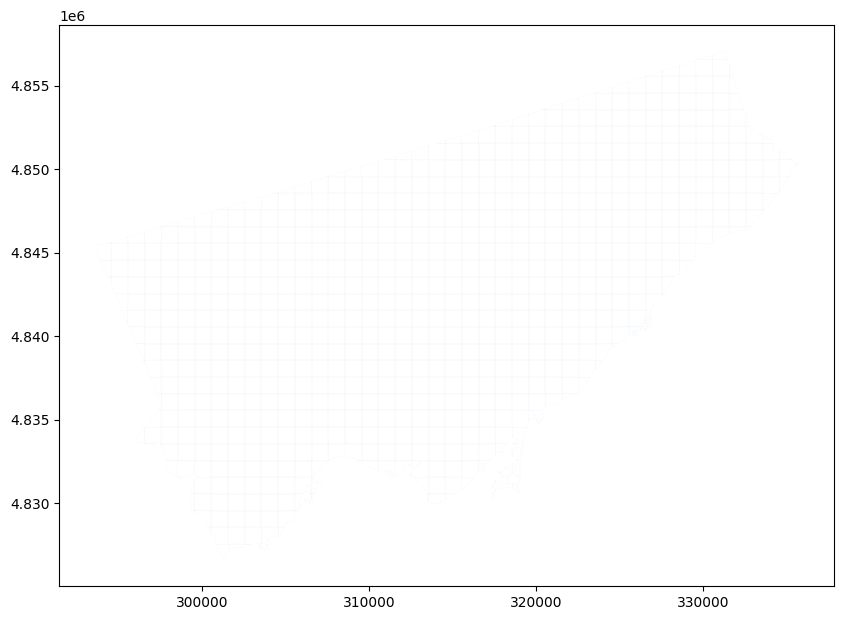

In [6]:
base_map.boundary.plot(linewidth=0.01, figsize=(10,10))

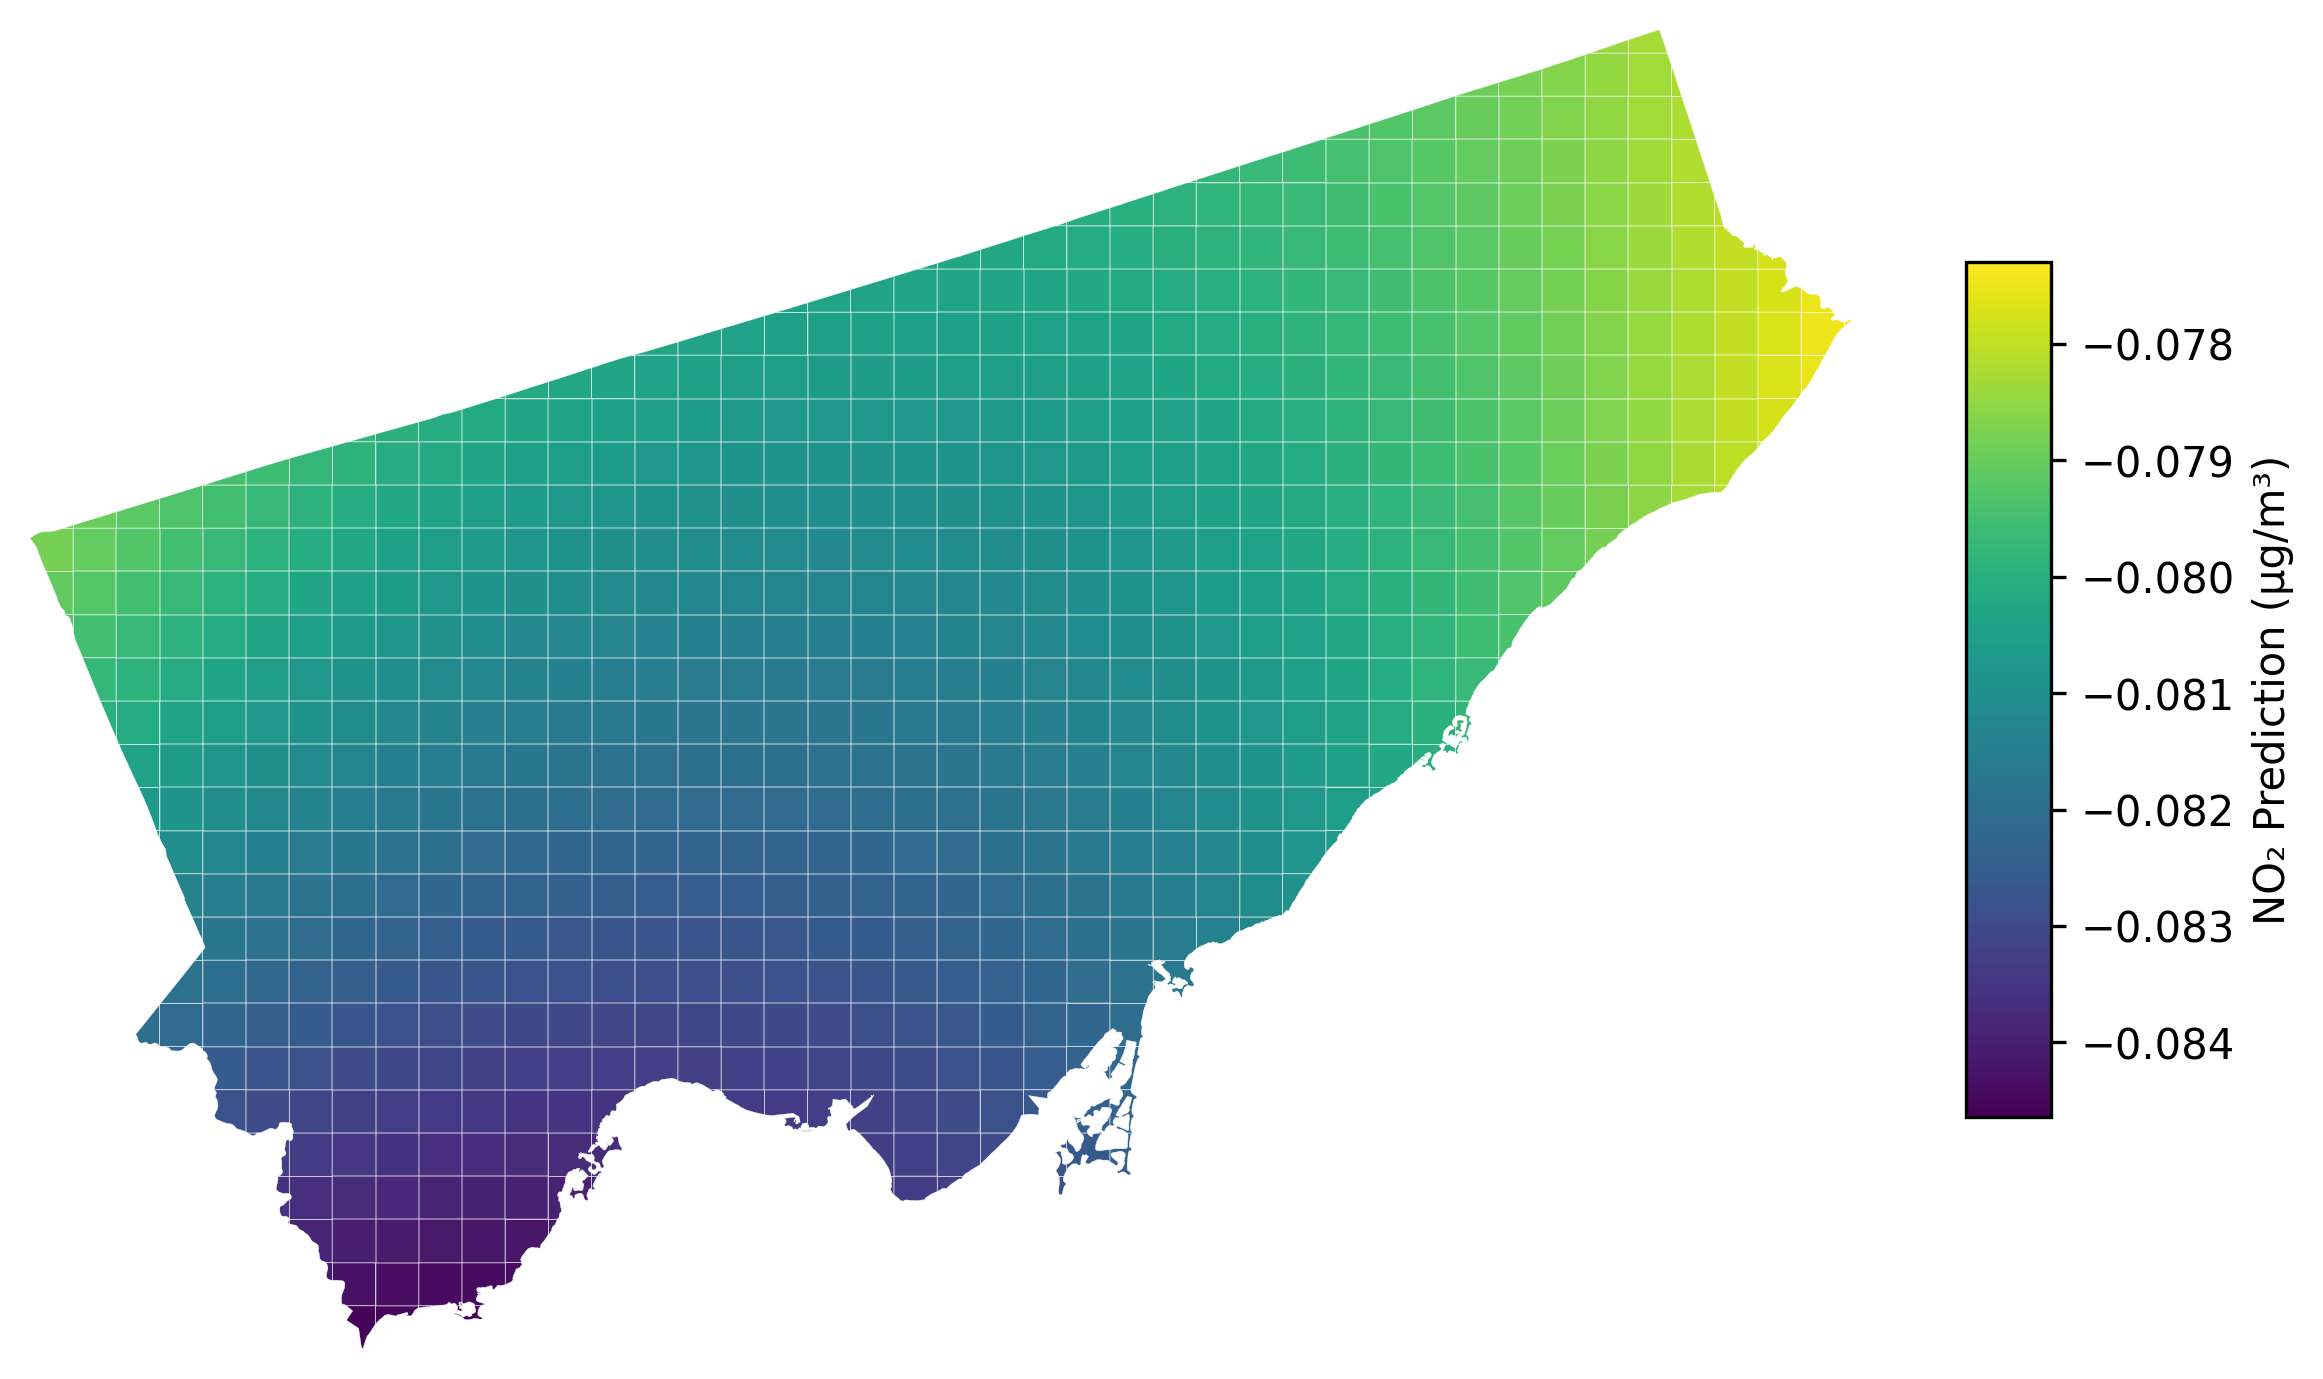

In [42]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# Parameters — easy to adjust
figsize = (8, 6)         # width, height in inches
dpi = 300                # resolution
line_width = 0.1         # boundary thickness
view_box = None          # or specify as (xmin, xmax, ymin, ymax)
show_axes = False        # hide axes
legend_label = "NO₂ Prediction (µg/m³)"

# Set up figure and axis
fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

# Plot base boundary
base_map.boundary.plot(ax=ax, linewidth=line_width, color="white", zorder=1)

# Determine legend (colorbar) scale
vmin = 0
vmax = max_NO2

# Create color normalization
norm = colors.Normalize(vmin=vmin, vmax=vmax)

# Plot NO2_pred
time_slices[0].plot(
    column="NO2_pred",
    cmap="viridis",
    ax=ax,
    legend=True,
    # norm=norm,
    zorder=-1,
    legend_kwds={
        "label": legend_label,
        "orientation": "vertical",
        "shrink": 0.5,
        "aspect": 10
    }
)

# Adjust view
if view_box:
    ax.set_xlim(view_box[0], view_box[1])
    ax.set_ylim(view_box[2], view_box[3])
else:
    ax.set_xlim(base_gdf.total_bounds[0], base_gdf.total_bounds[2])
    ax.set_ylim(base_gdf.total_bounds[1], base_gdf.total_bounds[3])

# Hide axes if desired
if not show_axes:
    ax.set_axis_off()

plt.tight_layout()
plt.show()

def plot_wind_field(gdf, ax, scale=300, **kwargs):
    """
    Plot wind vectors on an existing matplotlib axis (black arrows).

    Parameters
    ----------
    gdf : GeoDataFrame
        Must contain columns 'geometry', 'wind_x_pred', 'wind_y_pred'.
    ax : matplotlib Axes
        Axis to draw the quiver plot on.
    scale : float, optional
        Scaling factor for arrow length (default=300).
    kwargs : dict
        Additional keyword arguments passed to ax.quiver().

    Returns
    -------
    qv : matplotlib.quiver.Quiver
        Handle to the quiver plot.
    """
    import numpy as np

    # Compute centroids
    centroids = gdf.geometry.centroid
    cx, cy = centroids.x, centroids.y

    # Plot black wind vectors (no color mapping)
    qv = ax.quiver(
        cx, cy,
        gdf["wind_x_pred"], gdf["wind_y_pred"],
        color="black",
        angles="xy", scale_units="xy", scale=scale,
        zorder = 2,
        width=0.015, headwidth=3, headlength=4, headaxislength=3, **kwargs
    )

    return qv

qv = plot_wind_field(slice, ax)
plt.show()

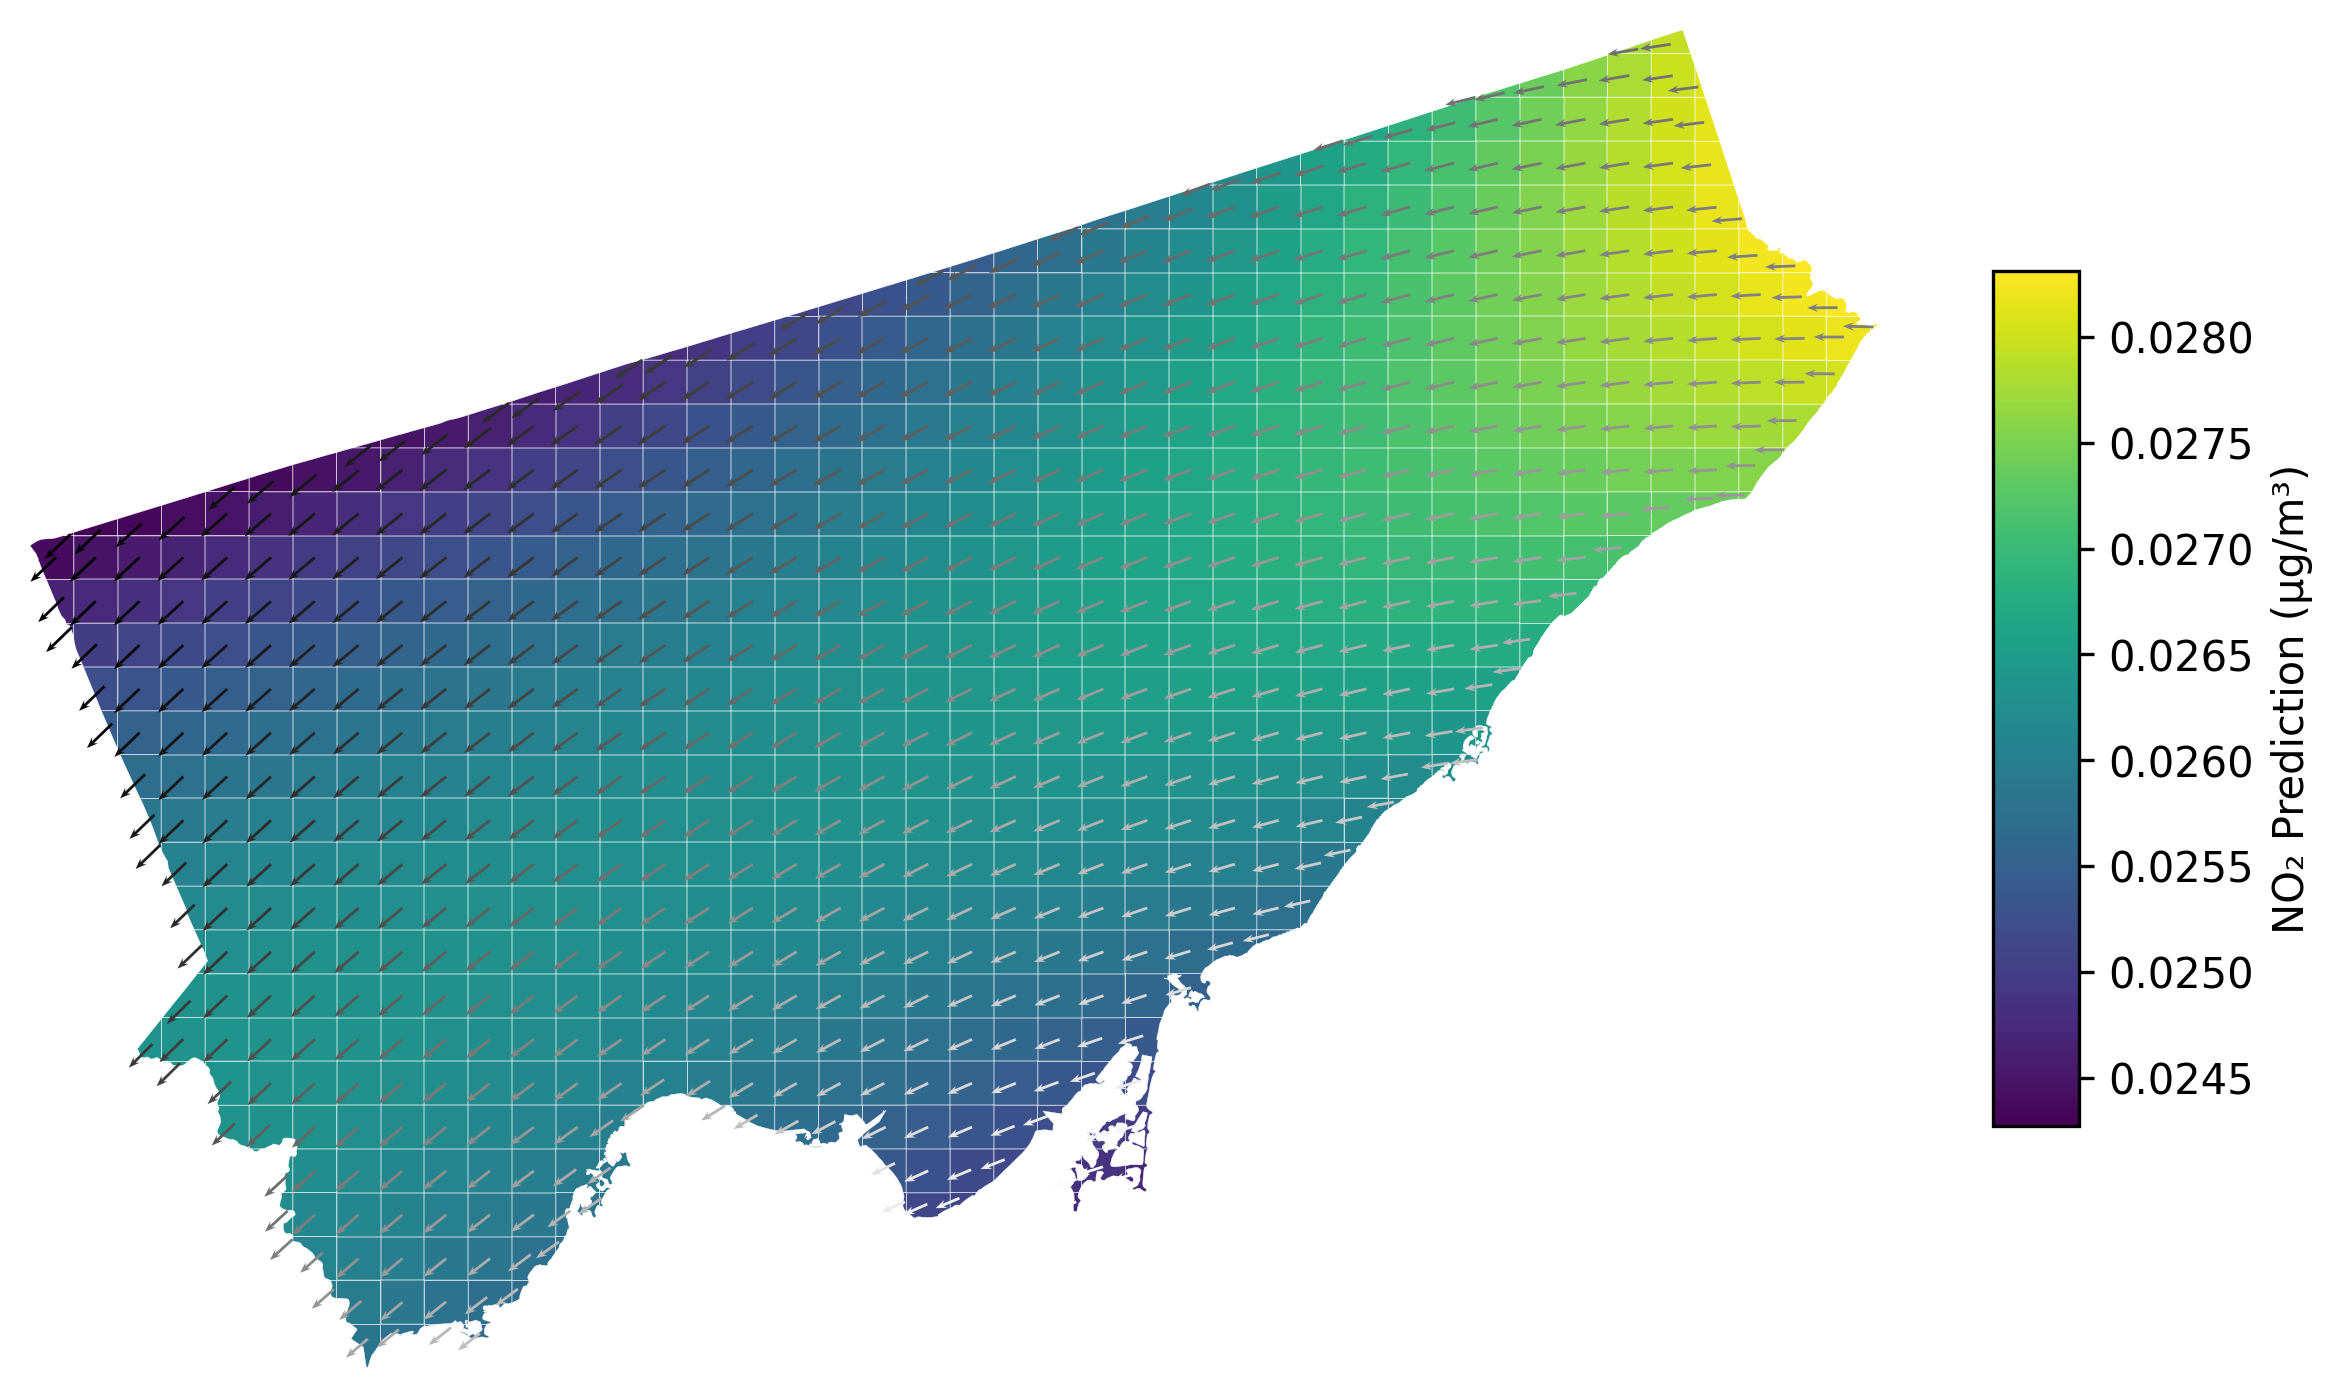

In [53]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

# ======================
# Define the function first
# ======================
def plot_wind_field(gdf, ax, scale=None, cmap="binary", normalize=False, **kwargs):
    """
    Plot wind vectors with color and length representing wind speed.

    Parameters
    ----------
    gdf : GeoDataFrame
        Must contain 'geometry', 'wind_x_pred', 'wind_y_pred'.
    ax : matplotlib Axes
        Axis to draw the quiver plot on.
    scale : float or None, optional
        Scaling factor for arrow length (None = auto). Smaller → longer arrows.
    cmap : str, optional
        Colormap for arrow colors based on wind speed (default='plasma').
    normalize : bool, optional
        If True, normalizes vectors to uniform length (color still encodes magnitude).
    kwargs : dict
        Extra keyword args passed to ax.quiver().

    Returns
    -------
    qv : matplotlib.quiver.Quiver
        Handle to the quiver plot (for colorbar).
    """
    gdf = gdf.copy()
    gdf["wind_speed"] = np.sqrt(gdf["wind_x_pred"]**2 + gdf["wind_y_pred"]**2)

    # Optionally normalize direction only (uniform length, color shows magnitude)
    if normalize:
        gdf["wind_x_plot"] = gdf["wind_x_pred"] / gdf["wind_speed"].replace(0, np.nan)
        gdf["wind_y_plot"] = gdf["wind_y_pred"] / gdf["wind_speed"].replace(0, np.nan)
    else:
        gdf["wind_x_plot"] = gdf["wind_x_pred"]
        gdf["wind_y_plot"] = gdf["wind_y_pred"]

    centroids = gdf.geometry.centroid
    cx, cy = centroids.x, centroids.y

    qv = ax.quiver(
        cx, cy,
        gdf["wind_x_plot"], gdf["wind_y_plot"],
        gdf["wind_speed"],              # color by speed
        angles="xy", scale_units="xy", scale=scale,
        cmap=cmap, width=0.0015,
        headwidth=3, headlength=4, headaxislength=3,
        zorder=3, **kwargs
    )

# ======================
# Main plotting section
# ======================

# Parameters
figsize = (8, 6)
dpi = 300
line_width = 0.1
view_box = None
show_axes = False
legend_label = "NO₂ Prediction (µg/m³)"

# Set up figure and axis
fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

# Plot base boundary
base_map.boundary.plot(ax=ax, linewidth=line_width, color="white", zorder=1)

# Determine legend (colorbar) scale
vmin = 0
vmax = max_NO2

# Color normalization
# norm = colors.Normalize(vmin=vmin, vmax=vmax)

# Plot NO₂ background
time_slices[20].plot(
    column="NO2_pred",
    cmap="viridis",
    ax=ax,
    legend=True,
    # norm=norm,
    zorder=-1,
    legend_kwds={
        "label": legend_label,
        "orientation": "vertical",
        "shrink": 0.5,
        "aspect": 10,
    },
)

# ✅ Overlay black wind vectors
qv = plot_wind_field(time_slices[0], ax=ax, scale=0.05)
# Adjust view
if view_box:
    ax.set_xlim(view_box[0], view_box[1])
    ax.set_ylim(view_box[2], view_box[3])
else:
    ax.set_xlim(base_gdf.total_bounds[0], base_gdf.total_bounds[2])
    ax.set_ylim(base_gdf.total_bounds[1], base_gdf.total_bounds[3])

# Hide axes if desired
if not show_axes:
    ax.set_axis_off()

plt.tight_layout()
plt.show()

<Axes: >

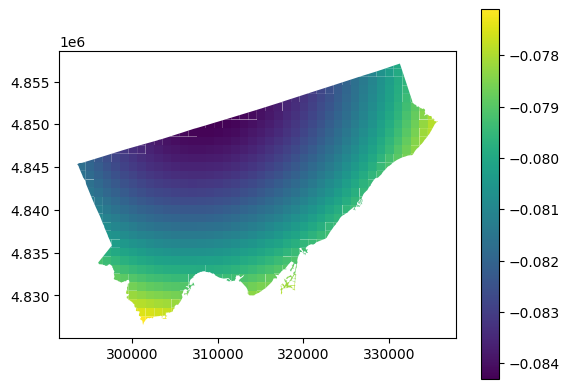

In [8]:
time_slices[10].plot(column="NO2_pred", legend=True)

<Axes: >

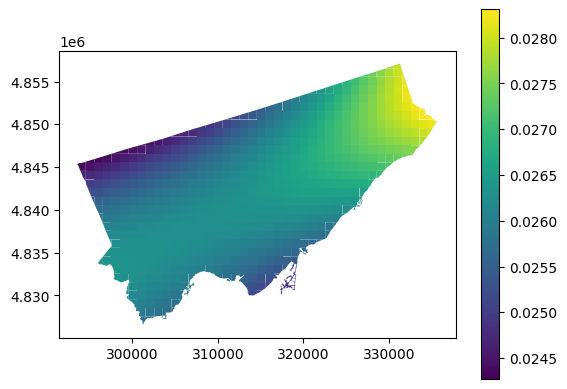

In [9]:
time_slices[20].plot(column="NO2_pred", legend=True)

<Axes: >

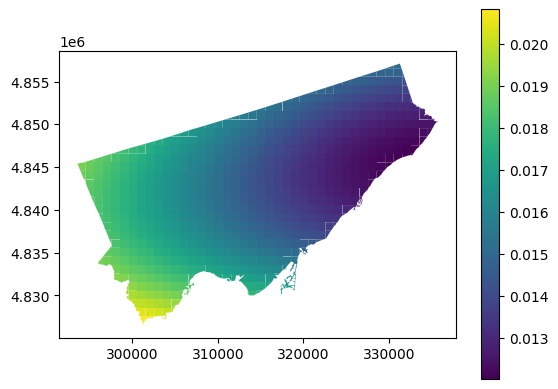

In [10]:
time_slices[30].plot(column="NO2_pred", legend=True)

<Axes: >

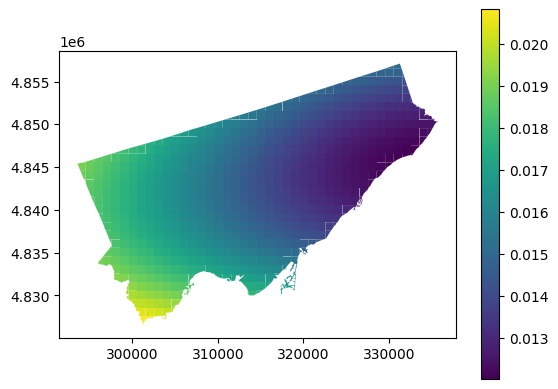

In [11]:
time_slices[30].plot(column="NO2_pred", legend=True)